In [1]:
import os
import numpy as np
import pandas as pd
# from PIL import Image
from matplotlib import pyplot as plt
# import seaborn as sns
from astropy.units import imperial
from gwpy.timeseries import TimeSeries
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython.display import display

# Load Data

In [31]:
# Following load code adapted from:
#  https://www.kaggle.com/xuzongniubi/g2net-efficientnet-b7-baseline-training

train_meta = pd.read_csv('../../data/training_labels.csv')
test_meta = pd.read_csv('../../data/sample_submission.csv')

def get_train_file_path(image_id):
    return "../../data/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "../../data/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train_meta['file_path'] = train_meta['id'].apply(get_train_file_path)
test_meta['file_path'] = test_meta['id'].apply(get_test_file_path)

In [34]:
def GetData(train_meta, num_samples, starting_idx=0):
    
    data = np.zeros((num_samples, 3, 4096))
    labels = np.zeros(num_samples)
    for i in range(starting_idx, starting_idx + num_samples):
        data[i] = np.load(train_meta.loc[i, 'file_path'])
        labels[i] = train_meta['target'][i]
            
    return data, labels

In [33]:
data, labels = GetData(train_meta, 200)
print(data.shape)

# print(np.sum(labels))
# print(np.sum(labels[:80]))

(200, 3, 4096)


# Make Spectrograms

In [30]:
def MinMaxNorm(img):
    # Use min-max normalization to scale all pixels to values between 0 and 1.
    scaled = np.zeros(img.shape)
    for i in range(img.shape[2]):
        scaled[:, :, i] = (img[:, :, i] - np.min(img[:, :, i])) / (np.max(img[:, :, i]) - np.min(img[:, :, i]))
        
    return scaled

def MakeSpectrograms(data, method='channel', size=None, normalize=True):
    # NOTE: Only 'channel' method is implemented at the moment.
    
    for i in range(len(data)):
        tseries0 = TimeSeries(data[i][0], sample_rate=2048)
        tseries1 = TimeSeries(data[i][1], sample_rate=2048, t0=2)
        tseries2 = TimeSeries(data[i][2], sample_rate=2048, t0=4)

        qt0 = tseries0.q_transform(frange=(30, 500), qrange=(100, 110))
        qt1 = tseries1.q_transform(frange=(30, 500), qrange=(100, 110))
        qt2 = tseries2.q_transform(frange=(30, 500), qrange=(100, 110))

        temp = np.stack((qt0.value.tolist(), qt1.value.tolist(), qt2.value.tolist()), axis=-1)
        
        if (size is not None and len(size) == 2):
            temp2 = tf.image.resize(temp, size, preserve_aspect_ratio=True)

            # If on the first iteration, create an array to hold the data, now that we know the size.
            if (i == 0):
                qt = np.zeros((data.shape[0], temp2.shape[0], temp2.shape[1], 3))
                
            if (normalize):
                qt[i] = MinMaxNorm(temp2)
            else:
                qt[i] = temp2
            
        else:
            if (i == 0):
                qt = np.zeros((data.shape[0], temp.shape[0], temp.shape[1], 3))
            
            if (normalize):
                qt[i] = MinMaxNorm(temp)
            else:
                qt[i] = temp

#     print(f'Type = {type(qt_channels)}, shape = {qt_channels.shape}')

    return qt

In [6]:
qt = MakeSpectrograms(data, size=(128, 128))

In [7]:
print(qt.shape)
print(np.min(qt[0, ...]), np.max(qt[0, ...]))

(200, 128, 120, 3)
0.0 1.0


# Build CNN

Following tutorial here: https://www.tensorflow.org/tutorials/images/cnn

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Build Model

In [23]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(32, (12, 12), activation='relu', input_shape=(qt.shape[1], qt.shape[2], qt.shape[3])))
model.add(layers.MaxPooling2D((8, 8)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 117, 109, 32)      13856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

### Compile and Train Model

In [24]:
print(qt[:9].shape)
print(qt[8:].shape)
print(train_meta.loc[:8, 'target'].shape)

foo = [1, 2, 3, 4]
bar = np.array([1, 2, 3, 4])
print(foo[:3])
print(bar[:3])

(9, 128, 120, 3)
(192, 128, 120, 3)
(9,)
[1, 2, 3]
[1 2 3]


In [25]:
model.compile(optimizer='sgd',#'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(qt[:160], labels[:160], epochs=200, 
                    validation_data=(qt[160:], labels[160:]))

Epoch 1/200
5/5 [==============================] - 1s 60ms/step - loss: 0.6942 - accuracy: 0.4812 - val_loss: 0.6941 - val_accuracy: 0.4750
Epoch 2/200
5/5 [==============================] - 0s 19ms/step - loss: 0.6930 - accuracy: 0.5188 - val_loss: 0.6919 - val_accuracy: 0.5500
Epoch 3/200
5/5 [==============================] - 0s 19ms/step - loss: 0.6921 - accuracy: 0.5688 - val_loss: 0.6895 - val_accuracy: 0.7000
Epoch 4/200
5/5 [==============================] - 0s 19ms/step - loss: 0.6914 - accuracy: 0.5625 - val_loss: 0.6877 - val_accuracy: 0.6750
Epoch 5/200
5/5 [==============================] - 0s 18ms/step - loss: 0.6908 - accuracy: 0.5500 - val_loss: 0.6864 - val_accuracy: 0.6500
Epoch 6/200
5/5 [==============================] - 0s 19ms/step - loss: 0.6901 - accuracy: 0.5375 - val_loss: 0.6855 - val_accuracy: 0.6000
Epoch 7/200
5/5 [==============================] - 0s 19ms/step - loss: 0.6902 - accuracy: 0.5375 - val_loss: 0.6851 - val_accuracy: 0.6250
Epoch 8/200
5/5 [===

### Evaluate Model

2/2 - 0s - loss: 0.7273 - accuracy: 0.6000
0.6000000238418579


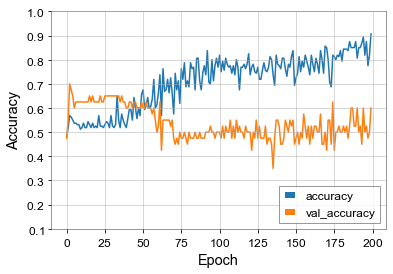

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(qt[160:], labels[160:], verbose=2)

print(test_acc)

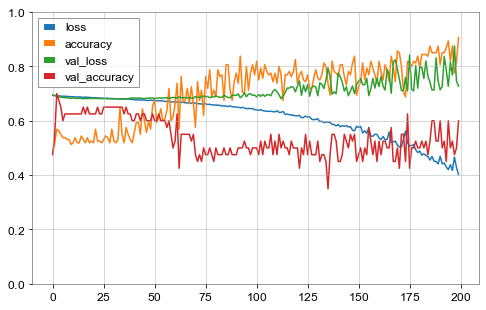

In [28]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig(\"keras_learning_curves_plot\")
plt.show()

In [7]:
train_meta.head

<bound method NDFrame.head of                 id  target                          file_path
0       00000e74ad       1  ./data/train/0/0/0/00000e74ad.npy
1       00001f4945       0  ./data/train/0/0/0/00001f4945.npy
2       0000661522       0  ./data/train/0/0/0/0000661522.npy
3       00007a006a       0  ./data/train/0/0/0/00007a006a.npy
4       0000a38978       1  ./data/train/0/0/0/0000a38978.npy
...            ...     ...                                ...
559995  ffff9a5645       1  ./data/train/f/f/f/ffff9a5645.npy
559996  ffffab0c27       0  ./data/train/f/f/f/ffffab0c27.npy
559997  ffffcf161a       1  ./data/train/f/f/f/ffffcf161a.npy
559998  ffffd2c403       0  ./data/train/f/f/f/ffffd2c403.npy
559999  fffff2180b       0  ./data/train/f/f/f/fffff2180b.npy

[560000 rows x 3 columns]>